# Métodos Conservativos - Tarea 4
 
### Punto 1:

Evolucionaremos la ecuación de advección 
\begin{equation}
u_t = c u_x
\end{equation}
 y la ecuación de Burguers 
\begin{equation}
u_t = \frac{1}{2}(u^2)_x
\end{equation}

con el método MP5. Este utiliza un polinomio de grado cuarto para aproximar $v_{j+ \frac{1}{2}}$, interpola la $f(u)$ la no $u$ y es de orden mayor a KT.

In [1]:
using OrdinaryDiffEq
using Plots


In [2]:
include("choques_utils.jl")

createMP5auxvectors (generic function with 1 method)

In [3]:
KurganovTadmor = false
MonotonicityPreserving5 =  true
#KurganovTadmor = true
#MonotonicityPreserving5 =  false

true

### Problema de advección 

In [4]:
problem = :advection

:advection

In [5]:
#La vel maxima es para ajustar la disipación del método y garantizar estabilidad

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

advectionspeed (generic function with 1 method)

In [ ]:
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

Definimos la función Flujo de los problemas
$$ u_t = F(u)_x$$

In [7]:
N = 2000
N_FIELDS = 1

#Datos espaciales para el problema
start = 0.0
stop = 2.0*pi
x = range(start, stop =stop, length = N+1)[1:end-1] #de manera que no incluya el último punto
dx = Float64(x.step)  #Δx
h = 1.0/dx

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :burgers
    eqpars = false
end

1.0

In [8]:
#Definimos el intervalo de integración y el paso dt
T = 1.0
tspan = (0.0, T)

(0.0, 1.0)

In [34]:
#Inicializamos el dato
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)
#@. u[:,1] = 0.5 + sin(x)

x0 = 1.; x1 = 5.

for i in 1:N
    if x[i] > x0 && x[i] < x1
        u[i,1] = (x[i] - x0)^10 * (x[i] - x1)^10 / (x1-x0)^12 *20
       
    end
end

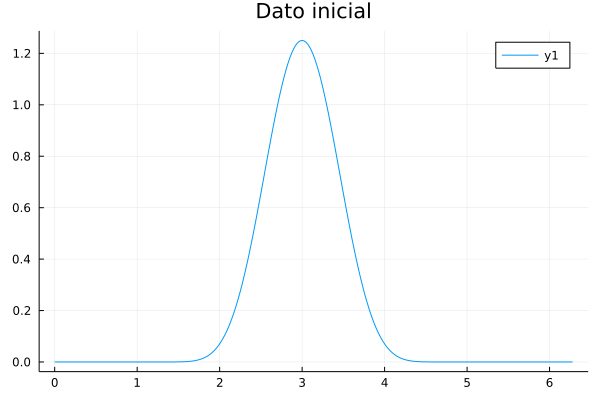

In [35]:
plot(x , u[:,1] , title= "Dato inicial")

In [36]:
#Elegimos el método que queremos ver
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método MP5


In [37]:
prob = ODEProblem(scheme!,u,tspan,par);

In [38]:
sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\AdveccionMP5.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\AdveccionMP5.gif")
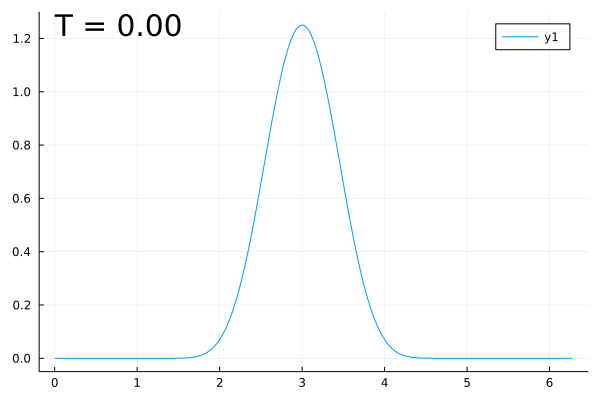

In [39]:
using Printf
anim = @animate for t in sol.t
    plt = plot(x, sol(t), ylims = (-0.05,1.3))
    annotate!(plt, 0.0, 1.25, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "AdveccionMP5.gif", fps = 30)

Constatemos que la solución se mueve a velocidad constante

In [60]:
function f(t)
b=1.0
c=0
for i in 1:2000
a=sol(t)[i,1]
    if a > b
        b=a
        c=i
    end
end
return c
end

function ff(t)
b=1.
c=0
for i in 1:2000
a=sol(t)[i,1]
    if a > b
        b=a
        c=i
    end
end
return b
end

ff (generic function with 1 method)

In [61]:
f(0.)

956

In [62]:
t1=0.2
t2=0.3

vel=(f(t2)-f(t1))/(t2-t1)

310.00000000000006

In [97]:
#h = zeros(5) #punto a seguir
t = zeros(5) #tiempo
vel= zeros(5) #velocidad

for i = 1:5
 # h[i] = ff(i*0.2)
  t[i] = i*0.2
end

for i = 1:5
  vel[i] = (f(i*0.2)-f(i*0.2-0.2))/(i*0.2-(i*0.2-0.2))
end

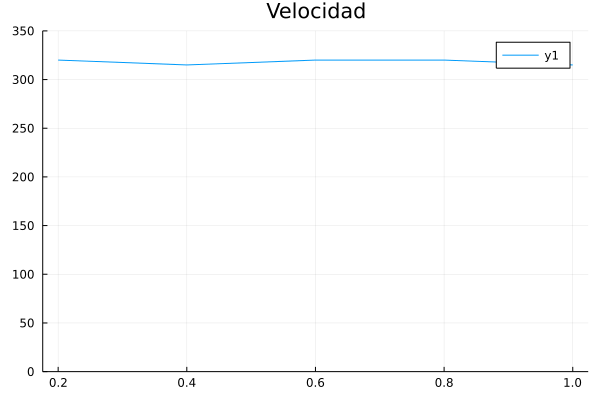

In [98]:
plot(t,vel,title="Velocidad",ylim= (0.,350.))

###  Problema de Burgers

 Tenemos 
 \begin{equation}
 \partial_t u + u \partial_x u =0
 \end{equation}
 
 Sabemos que si $x(t)$ es una curva caracteristica tenemos que 
 \begin{equation}
 u(x(t),t)=C
 \end{equation}
  Es decir que nuestra solución es constante sobre las curvas caracteristicas, las cuales vimos  que son rectas ya que tenemos
 \begin{equation}
\dot{x}=u(x(t),t)=C
 \end{equation}
Esto nos indica que en $t=0$ tenemos 
  \begin{equation}
 u(x(t=0),t=0)=u_0 (x_0)
 \end{equation}
 $x_0$ punto de partida de la caracteristica. Entonces 
  \begin{equation}
 x(t)=u_0(x_0)t+ x_0
 \end{equation}
  Si el dato inicial es decreciente en alguna región, tendremos una discontinuidad a tiempo finito. Es decir existen $x_0$ y $x_1$ tales que $u(x_0)>u(x_1)$, entonces las caracteristicas que arrancan desde esos dos puntos se encuentran en $t^*$.
 \begin{equation}
u_0(x_0)t^* + x_0=u_0(x_1)t^* + x_1
 \end{equation}
 Así 
 \begin{equation}
t^* = -\frac{x_0 -x_1}{u_0(x_0)-u_0(x_1)}
 \end{equation} 
 
 Si $x_0 $ tiende a $x_1$ tenemos 
  \begin{equation}
t^* = -\frac{1}{min (\dot{u_0(x)})}
 \end{equation} 
 
La derivada del dato inicial tiene un minimo en $x_{min}=3.45883$ que es donde ocurre el choque y esto nos da, segun lo visto, que el tiempo en el que ocurre el choque es $t^* =0.567 \approx 0.6$

In [5]:
problem = :burgers 

:burgers

In [6]:
#La vel maxima es para ajustar la disipación del método y garantizar estabilidad

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

burgersspeed (generic function with 1 method)

In [7]:
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

burgers! (generic function with 1 method)

In [8]:
N = 2000
N_FIELDS = 1

#Datos espaciales para el problema
start = 0.0
stop = 2.0*pi
x = range(start, stop =stop, length = N+1)[1:end-1] #de manera que no incluya el último punto
dx = Float64(x.step)  #Δx
h = 1.0/dx

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :burgers
    eqpars = false
end

false

In [9]:
#Inicializamos el dato
u = zeros(N, N_FIELDS)
du = copy(u)
#@. u[:,1] = 0.5 + sin(x)

x0 = 1.; x1 = 5.

for i in 1:N
    if x[i] > x0 && x[i] < x1
        u[i,1] = (x[i] - x0)^10 * (x[i] - x1)^10 / (x1-x0)^12 *20
       
    end
end

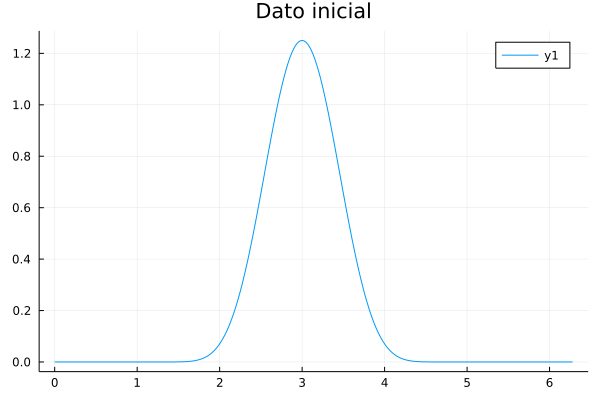

In [10]:
plot(x , u[:,1] , title= "Dato inicial")

In [11]:
#Definimos el intervalo de integración y el paso dt
Tbur = 5.0
tspanbur = (0.0, Tbur)

(0.0, 5.0)

In [12]:
#Elegimos el método que queremos ver
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método MP5


In [13]:
probbur = ODEProblem(scheme!,u,tspanbur,par);

In [14]:
solbur = solve(probbur,SSPRK33(),dt=dt, saveat = Tbur/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\burgers.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\burgers.gif")
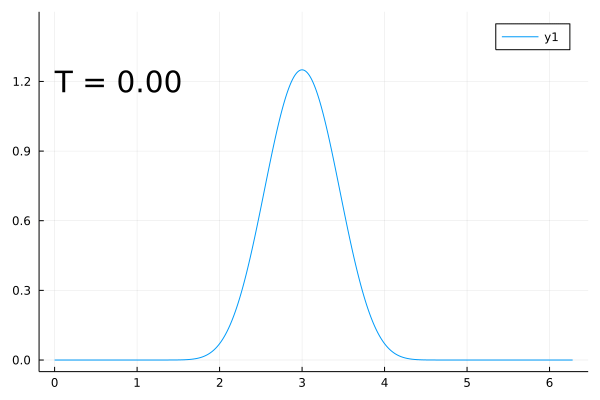

In [15]:
using Printf
anim = @animate for t in solbur.t
    plt = plot(x, solbur(t), ylims = (-0.05,1.5))
    annotate!(plt, 0.0, 1.2, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgersMP5.gif", fps = 10)

In [25]:
#posición del punto mas alto
function f(t)
b=0.2
c=0
for i in 1:2000
a=solbur(t)[i,1]
    if a > b
        b=a
        c=i
    end
end
return c
end

#punto mas alto
function ff(t)
b=0.2
c=0
for i in 1:2000
a=solbur(t)[i,1]
    if a > b
        b=a
        c=i
    end
end
return b
end

ff (generic function with 1 method)

In [26]:
t1=0.1
t2=0.2

vel=(f(t2)-f(t1))/(t2-t1)

400.0

In [30]:
h = zeros(20) #punto mas alto
t = zeros(20) #tiempo
vel= zeros(20) #velocidad

for i = 1:20
  h[i] = ff((i-1)*0.25)
  t[i] = (i-1)*0.25
end

for i = 1:20
  vel[i] = (f(i*0.25)-f(i*0.25-0.25))/(i*0.25-(i*0.25-0.25))
end

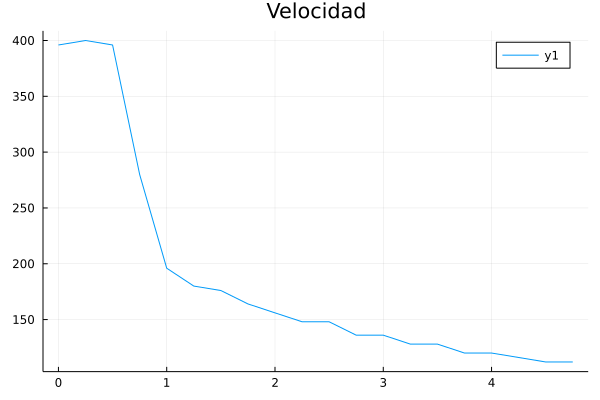

In [31]:
plot(t,vel,title="Velocidad")

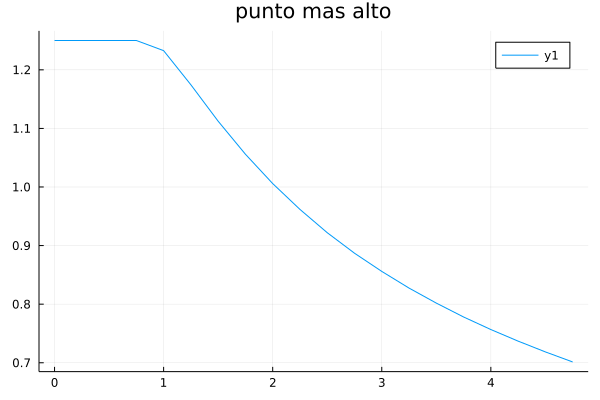

In [33]:
plot(t,h,title="punto mas alto")

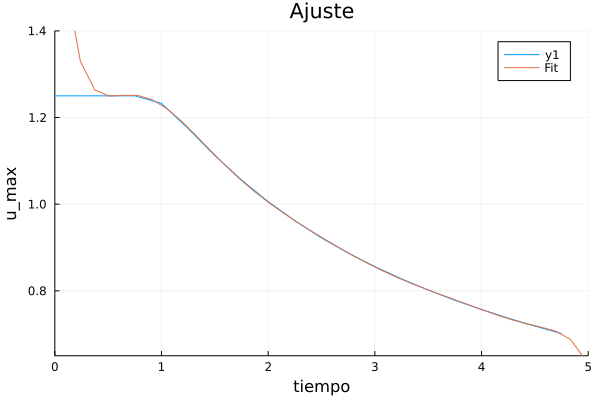

In [51]:
using Polynomials
pol=fit(t[3:end],h[3:end],9)

plot(t,h,yaxis = ("u_max", (0.65,1.4)),xaxis=("tiempo", (0,5)),title="Ajuste")
plot!(pol, label="Fit")

In [42]:
pol

Polynomial(2.7538383411413125 - 9.681700914945798*x + 25.2936340429361*x^2 - 35.37574193608429*x^3 + 29.685138288658866*x^4 - 15.946385645700891*x^5 + 5.629048315083183*x^6 - 1.3009604012442926*x^7 + 0.1896121808948418*x^8 - 0.015814286999992655*x^9 + 0.0005753820257975043*x^10)